In [61]:
%matplotlib

Using matplotlib backend: nbAgg


In [2]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import json
import pprint
import urllib
from urllib.parse import quote
import re

# Used for census.gov data
from census import Census

# Census API Key
from config import census_key
from config import yelp_key

c = Census(census_key, year=2013)

In [27]:
#File with ZIP Code data
file = 'input/zipcodes_stl2.csv'

# Read all ZIP codes with their Latitude and Longitude for the St. Louis City and St. Louis County area
# When testing use a small set of ZIP Codes: df_zip = df.iloc[0:5,:]
df_zip = pd.read_csv(file)

zip_count = df_zip.zip_code.count()
print(f"Total zip codes: {zip_count}")
df_zip.head()

Total zip codes: 45


,zip_code,county,latitude,longitude
0,63101,Saint Louis City,38.631551,-90.19300
1,63102,Saint Louis City,38.635200,-90.18702
2,63103,Saint Louis City,38.631451,-90.21415
3,63104,Saint Louis City,38.610701,-90.21362
4,63105,Saint Louis,38.645484,-90.32888


In [6]:
# Get ready to import yelp data
API_KEY=yelp_key

API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
MATCH_PATH = '/v3/businesses/matches'
SEARCH_PHONE_PATH = '/v3/businesses/search/phone'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash

In [7]:
def request(host, path, api_key, url_params=None):
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }
#     print(u'Querying {0} ...'.format(url))
#     print(headers)

    response = requests.request('GET', url, headers=headers, params=url_params)
    return response.json() #, my_url

In [ ]:
df_businesses = pd.DataFrame()
df_bus_total = pd.DataFrame()
prices = []
dict_total = {}

for index, row in df_zip.iterrows():
    row_zip = row[0]
    row_city = row[1]
    row_lat = row[2]
    row_long = row[3]
    #     print(index, row_zip, row_lat, row_long)
    url_params={"city":row_city, 'zip_code':row_zip,'latitude':row_lat,'longitude':row_long}
    dict_businesses = request(API_HOST, SEARCH_PATH, API_KEY, url_params)

    df_businesses['business_id']=[business["id"] for business in dict_businesses['businesses']]
    df_businesses['name']=[business["name"]for business in dict_businesses['businesses']]
    df_businesses['rating']=[business["rating"]for business in dict_businesses['businesses']]
    df_businesses['zip_code']=[business['location']["zip_code"]for business in dict_businesses['businesses']]
    df_businesses['review_count']=[business["review_count"]for business in dict_businesses['businesses']]

    for b in dict_businesses['businesses']:
        try:
            my_price = b['price']
            prices.append(my_price)
        except:
            prices.append('*')
    
#     dict_total.update(dict_businesses)
    
    df_bus_total = df_bus_total.append(df_businesses)

df_bus_total.head()

In [29]:
# Add prices info and cleanup
# df_bus_total['price'] = prices
df_bus_total = df_bus_total.loc[df_bus_total['price'] != '*']
bus_count = df_bus_total.business_id.count()
print(f"Total businesses: {bus_count}")
df_bus_total.head()

Total businesses: 842


,business_id,name,rating,zip_code,review_count,price
0,-6jVwUuXC1-dyr2YRCEU6Q,Anis Hyderabad Restaurant,4.0,63141,197,$$
1,-6jVwUuXC1-dyr2YRCEU6Q,Anis Hyderabad Restaurant,4.0,63141,197,$$
2,-W0tnXYJ4WuxLjzmbwlVAQ,Tavolo V,4.0,63112,204,$$
3,-bGw8ARHQucKWEHEkxpGFw,The Daily Bread Bakery & Cafe,4.0,63131,97,$
4,-hto0uJjh8KFQZGc9ZAcuQ,U-City Grill,4.0,63130,181,$


In [17]:
# Specify the file to write to
output_path = os.path.join("output", "business_data.csv")
df_bus_total.to_csv(output_path)

In [ ]:
# Drop duplicates
df_bus_total = df_bus_total.sort_values('business_id')
df_bus_total = df_bus_total.reset_index(drop=True)
df_bus_unique = df_bus_total.drop_duplicates(['business_id'], keep='first')

In [30]:
bus_uni_count = df_bus_unique.business_id.count()
print(f"Total unique businesses: {bus_uni_count}")
df_bus_unique.head()
# Optionally use a smaller data set: df_bus_unique_small = df_bus_unique[1:5]

Total unique businesses: 477


,business_id,name,rating,zip_code,review_count,price
0,-6jVwUuXC1-dyr2YRCEU6Q,Anis Hyderabad Restaurant,4.0,63141,197,$$
2,-W0tnXYJ4WuxLjzmbwlVAQ,Tavolo V,4.0,63112,204,$$
3,-bGw8ARHQucKWEHEkxpGFw,The Daily Bread Bakery & Cafe,4.0,63131,97,$
4,-hto0uJjh8KFQZGc9ZAcuQ,U-City Grill,4.0,63130,181,$
5,-kHHi8y4kaTI6WUVdJSdvQ,Fitz's,3.5,63130,619,$$


In [20]:
# Specify the file to write to
output_path = os.path.join("output", "business_unique_data.csv")
df_bus_unique.to_csv(output_path)

In [21]:
# Get reviews for each unique business
dict_rev_total = {}
dict_reviews = {}
df_reviews = pd.DataFrame()
df_rev_total = pd.DataFrame()

for index, row in df_bus_unique.iterrows():
    row_bus = row[0]
#     print(row_bus)
    REVIEW_PATH = BUSINESS_PATH + row_bus + '/reviews'
    dict_reviews = request(API_HOST, REVIEW_PATH, API_KEY)
#     pprint.pprint(dict_reviews)
    try:
        df_reviews['business_id']= [row_bus for review in dict_reviews['reviews']]
        df_reviews['review_id']=[review["id"]for review in dict_reviews['reviews']]
        df_reviews['rating']=[review["rating"]for review in dict_reviews['reviews']]
        df_reviews['name']=[review['user']["name"]for review in dict_reviews['reviews']]
        df_rev_total = df_rev_total.append(df_reviews)
    except:
        pass

In [31]:
rev_uni_count = df_rev_total.review_id.count()
print(f"Total reviews: {rev_uni_count}")
df_rev_total.head()

Total reviews: 1419


,business_id,review_id,rating,name
0,-6jVwUuXC1-dyr2YRCEU6Q,3xNxd1x6ew1QmGDLHxDFdA,5,Maggie Z.
1,-6jVwUuXC1-dyr2YRCEU6Q,CGGd6QCgqoCF67U5GnRaCw,5,Shraddz S.
2,-6jVwUuXC1-dyr2YRCEU6Q,Vi43zdZWfiZK6jPlGTWTGg,1,Hima R.
0,-W0tnXYJ4WuxLjzmbwlVAQ,YWzudmGlyDK5T10tVUk8Kw,5,Colleen S.
1,-W0tnXYJ4WuxLjzmbwlVAQ,GBkWTtokcnP-PMlMEXDLbQ,2,Alyssa G.


In [32]:
#COMMENT OUT THE RESET BELOW IF RAN MULTIPLE TIMES!!!!

df_rev_total.reset_index(inplace=True)

# create a list with names per review and take only the name before the 'space' as a first name
df_rev_total['short name']=""
short_name = []
for index, row in df_rev_total.iterrows():
#     print(row)
    short_name = re.split("( )",row[4])
#     print(short_name)
    df_rev_total.iloc[index, 5] = short_name[0].lower()

In [34]:
rev_uni_count = df_rev_total.review_id.count()
print(f"Total reviews: {rev_uni_count}")
df_rev_total.head()

Total reviews: 1419


,index,business_id,review_id,rating,name,short name
0,0,-6jVwUuXC1-dyr2YRCEU6Q,3xNxd1x6ew1QmGDLHxDFdA,5,Maggie Z.,maggie
1,1,-6jVwUuXC1-dyr2YRCEU6Q,CGGd6QCgqoCF67U5GnRaCw,5,Shraddz S.,shraddz
2,2,-6jVwUuXC1-dyr2YRCEU6Q,Vi43zdZWfiZK6jPlGTWTGg,1,Hima R.,hima
3,0,-W0tnXYJ4WuxLjzmbwlVAQ,YWzudmGlyDK5T10tVUk8Kw,5,Colleen S.,colleen
4,1,-W0tnXYJ4WuxLjzmbwlVAQ,GBkWTtokcnP-PMlMEXDLbQ,2,Alyssa G.,alyssa


In [39]:
file = 'input/gender names.csv'
df = pd.read_csv(file)
df = df.set_index('first_name')
df.head()

,nameprimary,gender,count
first_name,,,
aa,AA,Not Known,1
aabha,AABHA,Female,1
aabida,AABIDA,Female,1
aad,AAD,Male,1
aadarsh,AADARSH,Male,1


In [78]:
df_rev_total['gender']=""
gender = []
for index, row in df_rev_total.iterrows():
    try:
        gender = df.loc[str(row[5]),'gender']
    #     print(gender)
        df_rev_total.iloc[index, 6] = gender
    except:
        pass
df_rev_total.head()

# Drop reviews with where gender isn't found
df_rev_total = df_rev_total.loc[(df_rev_total['gender']!="") & (df_rev_total['gender']!="Both") & (df_rev_total['gender']!="Not Known")]

In [79]:
# Specify the file to write to
df_rev_total = df_rev_total.rename(columns={'rating':'reviewer_rating', 'name':'reviewer_full'})
output_path = os.path.join("output", "review_by_gender_data.csv")
df_rev_total.to_csv(output_path)

rev_gender_count = df_rev_total.review_id.count()
print(f"Total reviews with gender: {rev_gender_count}")

# Specify the file to write to
output_path = os.path.join("output", "review_data.csv")
df_rev_total.to_csv(output_path)

df_rev_total.head()

Total reviews with gender: 734


,index,business_id,review_id,reviewer_rating,reviewer_full,short name,gender
0,0,-6jVwUuXC1-dyr2YRCEU6Q,3xNxd1x6ew1QmGDLHxDFdA,5,Maggie Z.,maggie,Female
9,0,-hto0uJjh8KFQZGc9ZAcuQ,mYjfqARuUMocnIBb4PZi_A,5,Faye T.,faye,Female
10,1,-hto0uJjh8KFQZGc9ZAcuQ,TcARsdQZEtaRJpBDmShVPQ,1,Morae K.,morae,Female
11,2,-hto0uJjh8KFQZGc9ZAcuQ,oRmNn-G5pw5CDjIi-5s__Q,1,John K.,john,Male
12,0,-kHHi8y4kaTI6WUVdJSdvQ,zfHH4fQ1slhdGeT-mfQbMA,4,Ian C.,ian,Female


In [80]:
df_total = pd.merge(df_rev_total, df_bus_total,on=('business_id'))
# Somehow renaming columns duplicated rows
df_total = df_total.drop_duplicates()
# df_total.count()

In [81]:
# Specify the file to write to
output_path = os.path.join("output", "total_everything.csv")
df_total.to_csv(output_path)

total_count = df_total.review_id.count()
print(f"Total reviews: {total_count}")
df_total.head()

Total reviews: 734


,index,business_id,review_id,reviewer_rating,reviewer_full,short name,gender,name,rating,zip_code,review_count,price
0,0,-6jVwUuXC1-dyr2YRCEU6Q,3xNxd1x6ew1QmGDLHxDFdA,5,Maggie Z.,maggie,Female,Anis Hyderabad Restaurant,4.0,63141,197,$$
2,0,-hto0uJjh8KFQZGc9ZAcuQ,mYjfqARuUMocnIBb4PZi_A,5,Faye T.,faye,Female,U-City Grill,4.0,63130,181,$
3,1,-hto0uJjh8KFQZGc9ZAcuQ,TcARsdQZEtaRJpBDmShVPQ,1,Morae K.,morae,Female,U-City Grill,4.0,63130,181,$
4,2,-hto0uJjh8KFQZGc9ZAcuQ,oRmNn-G5pw5CDjIi-5s__Q,1,John K.,john,Male,U-City Grill,4.0,63130,181,$
5,0,-kHHi8y4kaTI6WUVdJSdvQ,zfHH4fQ1slhdGeT-mfQbMA,4,Ian C.,ian,Female,Fitz's,3.5,63130,619,$$


In [55]:
# df_zip = df_zip.rename(columns={'ZIP Code':'zip_code'})
# df_total['zip_code'] = pd.to_numeric(df_total['zip_code'])
# df_total_zip = pd.merge(df_total, df_zip, on='zip_code', how='outer')
# df_total_zip.head()

In [68]:
# # Specify the file to write to
# output_path = os.path.join("output", "total_everything.csv")
# df_total.to_csv(output_path)

In [90]:
total_reviews = df_total['gender'].value_counts()

plt.clf()
colors = ['lightskyblue', 'lightcoral']
labels = ['Women','Men']
patches, texts = plt.pie(men_sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(total_reviews, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("Yelp reviews Women vs Men")
plt.savefig("Images/Women_vw_Men.png")

total_reviews

Female    396
Male      338
Name: gender, dtype: int64

<IPython.core.display.Javascript object>


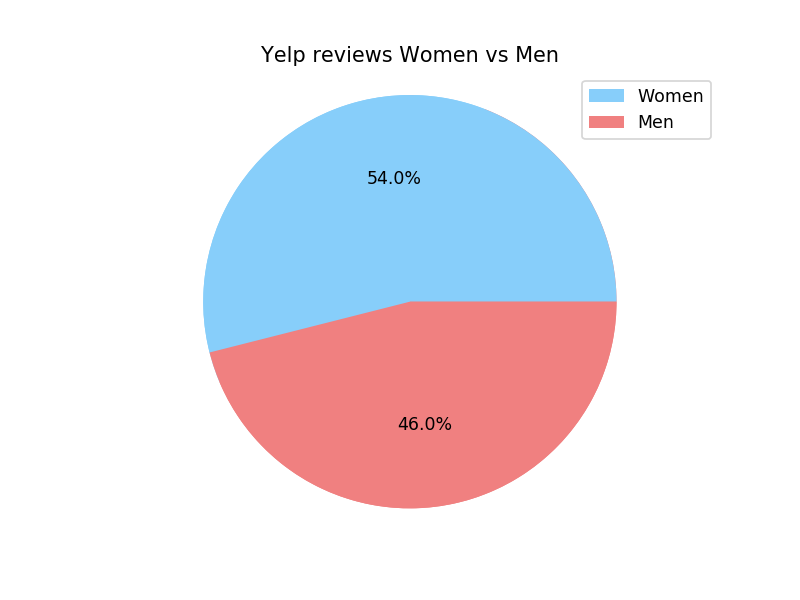

price
$       106
$$      212
$$$      19
$$$$      1
Name: price, dtype: int64

In [88]:
# use line below to bypass API calls
# df_total = pd.read_csv('output/total_everything.csv')

men_sizes = []
df_only_men = df_total.loc[(df_total["gender"] == 'Male')]
df_only_men_price_count = df_only_men.loc[(df_only_men["price"] != '*')]
df_only_men_price_count_gb = df_only_men_price_count.groupby(['price'])

men_sizes = df_only_men_price_count_gb['price'].count()
plt.clf()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
labels = ['\$','\$\$','\$\$\$','\$\$\$\$']

patches, texts = plt.pie(men_sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(men_sizes, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("Yelp reviews by Men by Price range")
plt.savefig("Images/Men_Price_Reviews.png")
men_sizes

In [89]:
women_sizes = []
df_only_women = df_total.loc[(df_total["gender"] == 'Female')]
df_only_women_price_count = df_only_women.loc[(df_only_women["price"] != '*')]
df_only_women_price_count_gb = df_only_women_price_count.groupby(['price'])

women_sizes = df_only_women_price_count_gb['price'].count()
plt.clf()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
labels = ['\$','\$\$','\$\$\$','\$\$\$\$']
patches, texts = plt.pie(men_sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(women_sizes, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("Yelp reviews by Women by Price range")
plt.savefig("Images/Women_Price_Reviews.png")

women_sizes

price
$       151
$$      227
$$$      17
$$$$      1
Name: price, dtype: int64

         men  women  other  total
Bracket                          
0-3       18     17      0     38
3.0-3.5   62     62      0    132
3.5-4    141    117      0    288
4.0-4.5  103    125      0    244
4.5-5     14     17      0     32


<IPython.core.display.Javascript object>


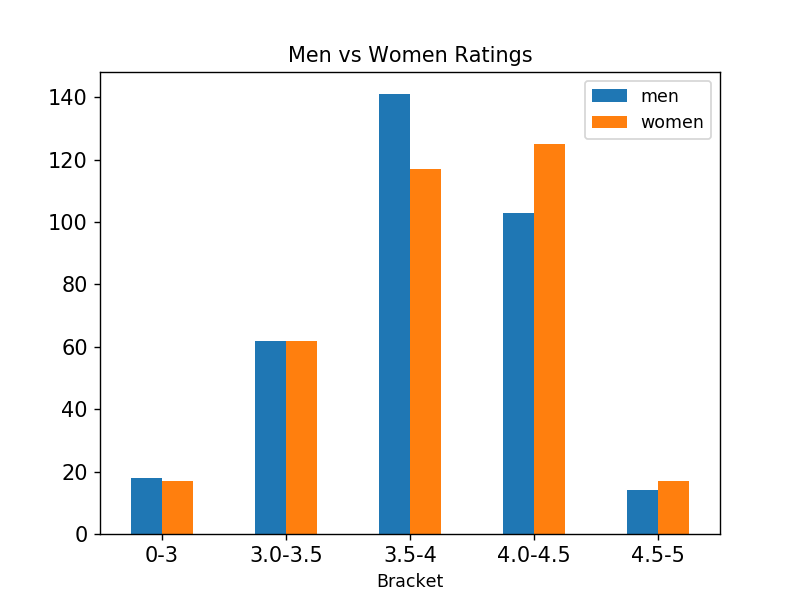

         men  women  other  total
Bracket                          
0-3       18     17      0     38
3.0-3.5   62     62      0    132
3.5-4    141    117      0    288
4.0-4.5  103    125      0    244
4.5-5     14     17      0     32


In [97]:
bins = [0,3,3.5,4,4.5,5]
group_names = ['0-3', '3.0-3.5','3.5-4','4.0-4.5','4.5-5']
# group_names = ['A', 'B','C','D','E']

s1 = pd.Series(group_names)
df_summary = pd.DataFrame(list(s1), columns=["Bracket"])
df_summary = df_summary.set_index(['Bracket'])

df_total['Bracket'] = pd.cut(df_total['rating'], bins, labels=group_names)
df_total_women = df_total.loc[df_total['gender']=='Female',['rating','Bracket']]
df_total_women = df_total_women.iloc[0:338,:]
df_total_men = df_total.loc[df_total['gender']=='Male',['rating','Bracket']]
df_total_men = df_total_men.iloc[0:338,:]
df_total_other = df_total.loc[(df_total['gender']!='Female') & (df_total['gender']!='Male'),['rating','Bracket']]

df_total_other_gb = df_total_other.groupby(['Bracket'])
df_total_women_gb = df_total_women.groupby(['Bracket'])
df_total_men_gb = df_total_men.groupby(['Bracket'])
df_total_gb = df_total.groupby(['Bracket'])
# df_total_other_gb = df_total_other.groupby(['Bracket'])

rating_women = df_total_women_gb.count()
rating_men = df_total_men_gb.count()
rating_other = df_total_other_gb.count()
rating_total = df_total_gb['rating'].count()


# rating_other = df_total_women_gb.count()
df_summary['men'] = rating_men
df_summary['women'] = rating_women
df_summary['other'] = rating_other
df_summary['total'] = rating_total

print(df_summary)

x_axis = group_names
x_axis
tick_locations = np.arange(0, 5, 1)
tick_locations
ax = df_summary[['men','women']].plot(kind='bar', title ="Men vs Women Ratings", legend=True,rot=0, fontsize=12)
ax.xlabel = 'Rating by Bracket'

plt.savefig("Images/Men_vs_Women_Rating.png")

print(df_summary)